In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
import itertools as it
%matplotlib inline

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
pandas version: 0.23.4
matplotlib version: 3.0.2
flopy version: 3.2.10


In [3]:
exe_name_mf = 'mf2005.exe'
exe_name_mt = 'mt3dms5b.exe'
exe_name_swt = 'swt_v4.exe'
workspace = os.path.join('.', 'SEAWAT-case')
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

In [4]:
swt = flopy.seawat.Seawat(modelname='test', exe_name=exe_name_swt, model_ws=workspace)

In [5]:
Lx = 2.
Lz = 1.
nlay = 50
nrow = 1
ncol = 100
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = 1.
henry_botm = np.linspace(henry_top - delv, 0., nlay)
qinflow = 5.702  #m3/day
#dmcoef = 0.57024
dmcoef = 1.62925 #m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.  #m/day
# save cell fluxes to unit 53
ipakcb = 53

In [6]:
dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=1, delr=delr,
                               delc=delc, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=1.5, nstp=15)

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1
bas = flopy.modflow.ModflowBas(swt, ibound, 0)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=1.e-8)

budgetfile = '{}.cbc'.format('test')
budget_filerecord = [budgetfile]

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(swt, save_every = True,
                             save_types=['SAVE HEAD', 'SAVE BUDGET'],
                             budget_filerecord=budget_filerecord,
                             compact=True)

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow / nlay])
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

In [7]:
# Create the basic MT3DMS model structure
#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=0.001)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swt_v4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

In [8]:
swt.write_input()
swt.run_model(silent=True, report=False)

(True, [])

In [9]:
# Load data
ucnobj = bf.UcnFile(os.path.join(workspace, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(workspace, 'test.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

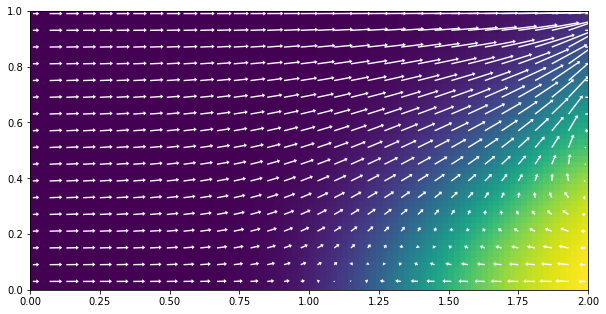

In [10]:
# Make the plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.imshow(concentration[:, 0, :], interpolation='nearest',
           extent=(0, Lx, 0, Lz))
y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
           qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)
#plt.savefig(os.path.join(workspace, 'henry.png'))
plt.show()

In [11]:
fname = os.path.join(workspace, 'test.hds')
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

Text(0.5, 1.0, 'Simulated Heads')

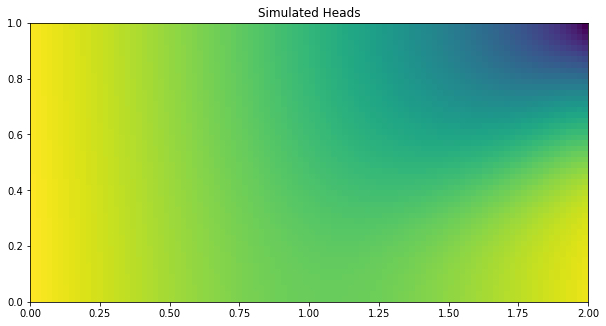

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz))
ax.set_title('Simulated Heads')